# **Практика 6: Атака по переносу (Transfer Attack) на модели ИИ**

Выполнил(а) студент **2** курса группы: **ББМО-02-23**

ФИО: **Кузина Анастасия Сергеевна**

# **Цель задания:**
Изучить концепцию атаки по переносу, где противоречивые примеры, созданные для одной модели, используются для атаки на другую модель. Это задание требует создания нескольких моделей, генерации противоречивых примеров для одной модели и проверки их на другой модели.

##**Задачи:**
1. Загрузить несколько моделей, обученных на датасете **MNIST**.
2. Изучить теоретические основы атаки по переносу.
3. Реализовать атаку **FGSM** на одну модель и проверить, как противоречивые примеры влияют на другую модель.
4. Оценить точность обеих моделей на противоречивых примерах и проанализировать переносимость атак.

##**Шаги выполнения:**

### **Шаг 1: Загружаем нужные для работы библиотеки**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

### **Шаг 2: Загрузка датасета MNIST и нормализация данных**

In [2]:
# Загружаем датасет MNIST:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Нормализуем данные:
train_images = train_images / 255.0
test_images = test_images / 255.0
# Преобразуем метки в one-hot encoding:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### **Шаг 3: Создаем две модели на датасете MNIST**
1. Простую полносвязную сеть
2. Свёрточную нейронную сеть (**CNN**)

In [4]:
# Создаём простую полносвязную модель (1):
model1 = Sequential([Flatten(input_shape=(28, 28)), Dense(128, activation='relu'), Dense(10, activation='softmax')])
# Компилируем модель:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Обучяем модель:
model1.fit(train_images, train_labels, epochs=5)
# Проверяем точность модели на обычных данных:
test_loss, test_acc = model1.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')
# Сохраняем модель в файл:
model1.save('mnist_model_fc.h5')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8768 - loss: 0.4359
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9622 - loss: 0.1265
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9770 - loss: 0.0762
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9819 - loss: 0.0590
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9871 - loss: 0.0410
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9712 - loss: 0.1021


Test accuracy on clean images: 0.9751999974250793


In [5]:
# Создаём модель свёрточной нейронной сети (2):
model2 = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')])
# Компилируем модель:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Обучаем модель:
model2.fit(train_images, train_labels, epochs=5)
# Проверяем точность модели на обычных данных:
test_loss, test_acc = model2.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')
# Сохраняем модель в файл:
model2.save('mnist_model_с.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9141 - loss: 0.2894
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9841 - loss: 0.0511
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9909 - loss: 0.0293
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9932 - loss: 0.0215
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9965 - loss: 0.0126
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9851 - loss: 0.0473


Test accuracy on clean images: 0.9878000020980835


###**Шаг 4: Теория атаки по переносу**

Атака по переносу — это метод, при котором противоречивые примеры, созданные для одной модели, применяются к другой модели. Это возможно, потому что модели часто имеют схожие слабости и могут совершать одинаковые ошибки на определенных данных, даже если они обучены на разных архитектурах.

В этом задании мы создадим противоречивые примеры для первой модели с помощью **FGSM** и затем проверим, насколько эти примеры могут атаковать вторую модель.

###**Шаг 5: Реализация атаки FGSM на полносвязную модель**

In [6]:
import numpy as np
# Создаём функцию для реализации FGSM атаки:
def fgsm_attack(image, epsilon, gradient):
  # Применяем знак градиента к изображению:
  perturbed_image = image + epsilon * np.sign(gradient)
  # Обрезаем значения, чтобы они оставались в пределах [0,1]:
  perturbed_image = np.clip(perturbed_image, 0, 1)
  return perturbed_image

# Вычисляем градиент:
def generate_adversarial_example(model, images, labels, epsilon):
    adversarial_images = []
    # Превращаем изображения в формат, подходящий для модели:
    for i in range(len(images)):
      image = tf.convert_to_tensor(images[i].reshape((1, 28, 28, 1)))
      label = labels[i]
      # Преобразуем label (one-hot вектор) в индекс:
      if len(label.shape) > 1 and label.shape[1] > 1:
          label = np.argmax(label),
      label = tf.convert_to_tensor(label)
      with tf.GradientTape() as tape:
          tape.watch(image)
          prediction = model(image)
          loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)
      gradient = tape.gradient(loss, image)
      # Применяем FGSM:
      adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
      adversarial_images.append(np.reshape(adversarial_image, (28, 28, 1)))
    return np.array(adversarial_images)
epsilon = 0.1
# Создаём противоречивые изображения для простой полносвязной модели:
adversarial_example = generate_adversarial_example(model1, test_images, test_labels, epsilon)

###**Шаг 6: Визуализация результатов проведенной атаки на полносвязную модель:**

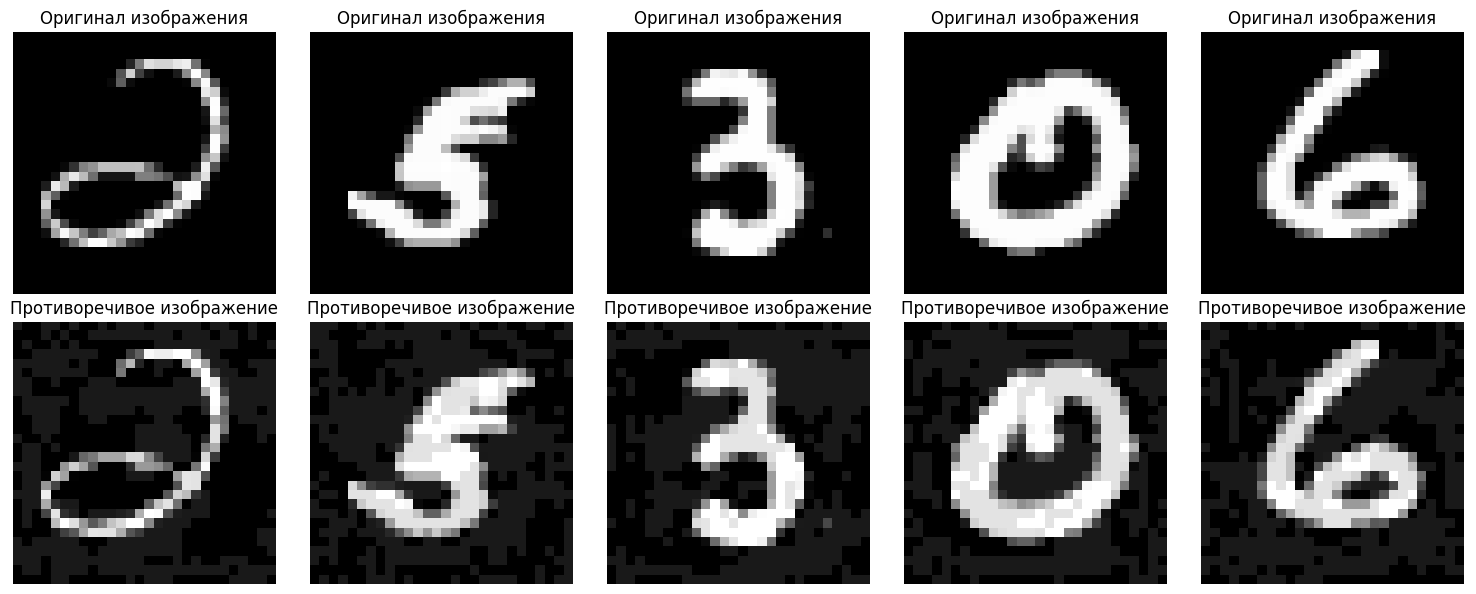

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Указываем количество изображений для отображения:
num_images = 5
# ВЫбираем случайные индексы:
random_indices = np.random.choice(len(test_images), num_images, replace=False)

# Созданём фигуры:
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    plt.subplot(2, num_images, i + 1)
    plt.title("Оригинал изображения")
    plt.imshow(test_images[idx], cmap="gray")
    plt.axis('off')

    plt.subplot(2, num_images, i + 1 + num_images)
    plt.title("Противоречивое изображение")
    plt.imshow(adversarial_example[idx].reshape(28, 28), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

###**Шаг 7: Оценка противоречивых примеров на обеих моделях**

In [10]:
# Оценим полносвязную модель на противоречивых примерах:
adversarial_loss1, adversarial_acc1 = model1.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
# Оценим свёрточную модель на противоречивых примерах:
adversarial_loss2, adversarial_acc2 = model2.evaluate(adversarial_example.reshape(10000, 28, 28),
test_labels)
print(f'Точность полносвязной модели: {adversarial_acc1}')
print(f'Точность свёрточной модели: {adversarial_acc2}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0798 - loss: 6.3487
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9564 - loss: 0.1345
Точность полносвязной модели: 0.10610000044107437
Точность свёрточной модели: 0.9639000296592712


**Вывод:** Атака, как видно, оказала незначительное влияние на точность свёрточной модели, снизив её всего на примерно 2% - это свидетельствует о её высокой устойчивости к переноск атак, созданных для полносвязной модели. А вот атака на полносвязную модель оказала очень серьезное влияние на точность, снизив её на 80% - что свидетельствует о её высокой уязвимости к атаке.

###**Шаг 8: Перейдем к реализации атаки FGSM на свёрточную модель**

In [11]:
# Создаём противоречивые изображения для свёрточной модели:
adversarial_example1 = generate_adversarial_example(model2, test_images, test_labels, epsilon)

###**Шаг 9: Визуализация результатов проведенной атаки на свёрточную модель:**

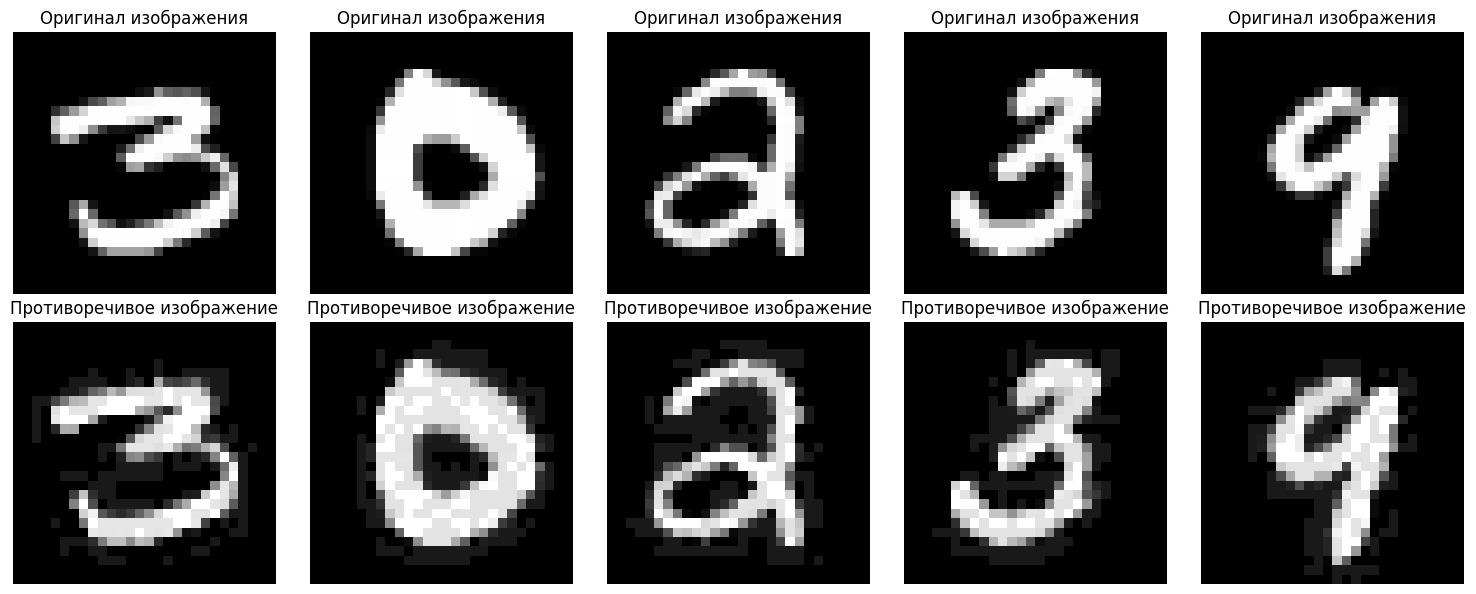

In [13]:
# Указываем количество изображений для отображения:
num_images = 5
# ВЫбираем случайные индексы:
random_indices = np.random.choice(len(test_images), num_images, replace=False)

# Создаём фигуры:
plt.figure(figsize=(15, 6))


for i, idx in enumerate(random_indices):
    plt.subplot(2, num_images, i + 1)
    plt.title("Оригинал изображения")
    plt.imshow(test_images[idx], cmap="gray")
    plt.axis('off')

    plt.subplot(2, num_images, i + 1 + num_images)
    plt.title("Противоречивое изображение")
    plt.imshow(adversarial_example1[idx].reshape(28, 28), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

###**Шаг 10: Оценка противоречивых примеров на обеих моделях**

In [15]:
# Оценка полносвязной модели на противоречивых примерах:
adversarial_loss11, adversarial_acc11 = model1.evaluate(adversarial_example1.reshape(10000, 28, 28),
test_labels)
# Оценка свёрточной модели на противоречивых примерах:
adversarial_loss22, adversarial_acc22 = model2.evaluate(adversarial_example1.reshape(10000, 28, 28),
test_labels)
print(f'Точность полносвязной модели: {adversarial_acc11}')
print(f'Точность свёрточной модели: {adversarial_acc22}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9515 - loss: 0.1593
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7267 - loss: 1.0305
Точность полносвязной модели: 0.9577000141143799
Точность свёрточной модели: 0.7422999739646912


**Вывод:** Ситуация совершенно противоположная: теперь свёрточная модель демонстрирует точность ниже, всего 74%, в то время как на полносвязную модель атака оказала незначительное влияние, снизив её точность примерно на 2%. Также сразу заметна разница в помехах на изображении

### **Вывод:** Атака FGSM между моделями переносится плохо. Результаты исследований показывают, что атака переноса, осуществляемая с использованием метода FGSM, может значительно снизить точность модели, особенно если атакующие примеры были сгенерированы именно для этой модели. В то же время, другая модель, продемонстрировавшая более высокую устойчивость к подобным атакам, оказывается менее уязвимой. Эти выводы подчеркивают необходимость разработки более защищённых моделей, которые могут сохранять свою точность даже при воздействии атак, перенесённых с других моделей. Кроме того, важно отметить, что создание устойчивых моделей не только повышает их надежность в условиях атак, но и способствует улучшению общей безопасности систем машинного обучения. Это открывает новые горизонты для применения таких моделей в критически важных областях, где точность и безопасность имеют первостепенное значение.